<a href="https://colab.research.google.com/github/Akash-infant/Taxi-trip-duration-prediction/blob/main/Time_series_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Approach - 1**

**Forecasting trip duration using Fb prophet**

In [ ]:
!pip install pyspark

Importing packages

In [ ]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
import pandas as pd
import datetime
from pyspark.sql.functions import col, udf
from pyspark.sql.types import FloatType
from geopy.distance import geodesic
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

Creating spark session

In [ ]:
conf = SparkConf().setAppName("TaxiDistanceForecasting")
sc = SparkContext(conf=conf)
spark = SparkSession(sc)

Loading data

In [ ]:
train_file = "/content/drive/My Drive/Taxi Demand/train.csv"
test_file = "/content/drive/My Drive/Taxi Demand/test.csv"



In [ ]:
train_df = spark.read.csv(train_file, header=True)
test_df = spark.read.csv(test_file,header=True)

In [ ]:
train_rows = train_df.count()
train_rows

1458644

In [ ]:
test_rows=test_df.count()
test_rows

625134

In [ ]:
train_df.show()

+---------+---------+-------------------+-------------------+---------------+-------------------+------------------+-------------------+------------------+------------------+-------------+
|       id|vendor_id|    pickup_datetime|   dropoff_datetime|passenger_count|   pickup_longitude|   pickup_latitude|  dropoff_longitude|  dropoff_latitude|store_and_fwd_flag|trip_duration|
+---------+---------+-------------------+-------------------+---------------+-------------------+------------------+-------------------+------------------+------------------+-------------+
|id2875421|        2|2016-03-14 17:24:55|2016-03-14 17:32:30|              1|-73.982154846191406|40.767936706542969|-73.964630126953125|40.765602111816406|                 N|          455|
|id2377394|        1|2016-06-12 00:43:35|2016-06-12 00:54:38|              1|-73.980415344238281|40.738563537597656|-73.999481201171875|40.731151580810547|                 N|          663|
|id3858529|        2|2016-01-19 11:35:24|2016-01-19 12:

**Feature engineering and EDA**

In [ ]:
# checking for null values
from pyspark.sql.functions import isnull, count, when

missing_values_expr = [count(when(isnull(c), c)).alias(c) for c in train_df.columns]

missing_values_df = train_df.agg(*missing_values_expr)

missing_values_df.show()

+---+---------+---------------+----------------+---------------+----------------+---------------+-----------------+----------------+------------------+-------------+
| id|vendor_id|pickup_datetime|dropoff_datetime|passenger_count|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|store_and_fwd_flag|trip_duration|
+---+---------+---------------+----------------+---------------+----------------+---------------+-----------------+----------------+------------------+-------------+
|  0|        0|              0|               0|              0|               0|              0|                0|               0|                 0|            0|
+---+---------+---------------+----------------+---------------+----------------+---------------+-----------------+----------------+------------------+-------------+



In [ ]:
train_df.printSchema()

root
 |-- id: string (nullable = true)
 |-- vendor_id: string (nullable = true)
 |-- pickup_datetime: string (nullable = true)
 |-- dropoff_datetime: string (nullable = true)
 |-- passenger_count: string (nullable = true)
 |-- pickup_longitude: string (nullable = true)
 |-- pickup_latitude: string (nullable = true)
 |-- dropoff_longitude: string (nullable = true)
 |-- dropoff_latitude: string (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- trip_duration: string (nullable = true)



In [ ]:
test_df.printSchema()

root
 |-- id: string (nullable = true)
 |-- vendor_id: string (nullable = true)
 |-- pickup_datetime: string (nullable = true)
 |-- passenger_count: string (nullable = true)
 |-- pickup_longitude: string (nullable = true)
 |-- pickup_latitude: string (nullable = true)
 |-- dropoff_longitude: string (nullable = true)
 |-- dropoff_latitude: string (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)



In [ ]:
@udf(returnType=FloatType())
def get_distance_udf(source_lat, source_long, dest_lat, dest_long):
    return geodesic((source_lat, source_long), (dest_lat, dest_long)).miles

# Apply the UDF to create a new column "distance"
train_df = train_df.withColumn("distance", get_distance_udf("pickup_latitude", "pickup_longitude", "dropoff_latitude", "dropoff_longitude"))

In [ ]:
train_df.show(5)

+---------+---------+-------------------+-------------------+---------------+-------------------+------------------+-------------------+------------------+------------------+-------------+---------+
|       id|vendor_id|    pickup_datetime|   dropoff_datetime|passenger_count|   pickup_longitude|   pickup_latitude|  dropoff_longitude|  dropoff_latitude|store_and_fwd_flag|trip_duration| distance|
+---------+---------+-------------------+-------------------+---------------+-------------------+------------------+-------------------+------------------+------------------+-------------+---------+
|id2875421|        2|2016-03-14 17:24:55|2016-03-14 17:32:30|              1|-73.982154846191406|40.767936706542969|-73.964630126953125|40.765602111816406|                 N|          455|0.9334063|
|id2377394|        1|2016-06-12 00:43:35|2016-06-12 00:54:38|              1|-73.980415344238281|40.738563537597656|-73.999481201171875|40.731151580810547|                 N|          663|1.1238492|
|id38

In [ ]:
test_df = test_df.withColumn("distance", get_distance_udf("pickup_latitude", "pickup_longitude", "dropoff_latitude", "dropoff_longitude"))
test_df.show(5)

+---------+---------+-------------------+---------------+-------------------+------------------+-------------------+------------------+------------------+---------+
|       id|vendor_id|    pickup_datetime|passenger_count|   pickup_longitude|   pickup_latitude|  dropoff_longitude|  dropoff_latitude|store_and_fwd_flag| distance|
+---------+---------+-------------------+---------------+-------------------+------------------+-------------------+------------------+------------------+---------+
|id3004672|        1|2016-06-30 23:59:58|              1|-73.988128662109375|40.732028961181641| -73.99017333984375|40.756679534912109|                 N|1.7043358|
|id3505355|        1|2016-06-30 23:59:53|              1|-73.964202880859375| 40.67999267578125|-73.959808349609375|40.655403137207031|                 N|1.7123582|
|id1217141|        1|2016-06-30 23:59:47|              1|  -73.9974365234375|40.737583160400391|-73.986160278320312|40.729522705078125|                 N|0.8122017|
|id2150126

+-------+-----------------+
|summary|    trip_duration|
+-------+-----------------+
|  count|          1458644|
|   mean|959.4922729603659|
| stddev|5237.431724497547|
|    min|                1|
|    max|              999|
+-------+-----------------+



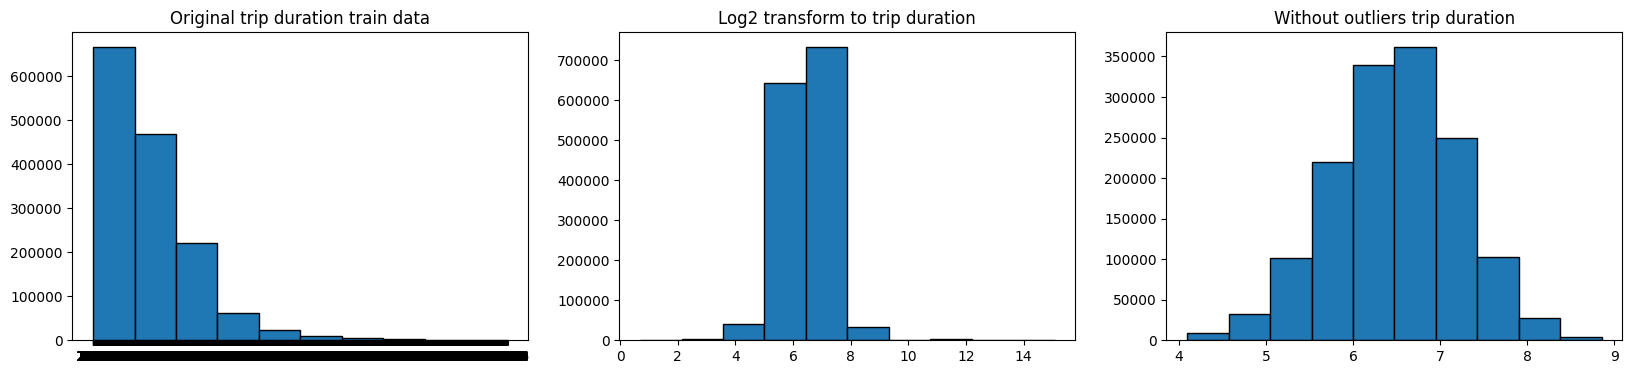

In [ ]:
from pyspark.sql.functions import col, log, mean, stddev
train_df.select("trip_duration").describe().show()

# Filter 1: Log2 transform to trip duration
train_fil1 = train_df.withColumn("trip_duration", log(col("trip_duration") + 1))

# Calculate mean and standard deviation
trip_duration_stats = train_fil1.select(mean("trip_duration").alias("mean"), stddev("trip_duration").alias("std")).collect()[0]
mean_value = trip_duration_stats["mean"]
std_dev_value = trip_duration_stats["std"]

# Define lower and upper bounds for filtering outliers (filter 2)
lower_bound = mean_value - (3 * std_dev_value)
upper_bound = mean_value + (3 * std_dev_value)

# Filter out the outliers
train_fil2 = train_fil1.filter((col("trip_duration") > lower_bound) & (col("trip_duration") < upper_bound))

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(20, 4))
axs[0].hist(train_df.select("trip_duration").toPandas()["trip_duration"], edgecolor='black')
axs[1].hist(train_fil1.select("trip_duration").toPandas()["trip_duration"], edgecolor='black')
axs[2].hist(train_fil2.select("trip_duration").toPandas()["trip_duration"], edgecolor='black')

# Set titles
axs[0].set_title('Original trip duration train data')
axs[1].set_title('Log2 transform to trip duration')
axs[2].set_title('Without outliers trip duration')

# Display plots
plt.show()

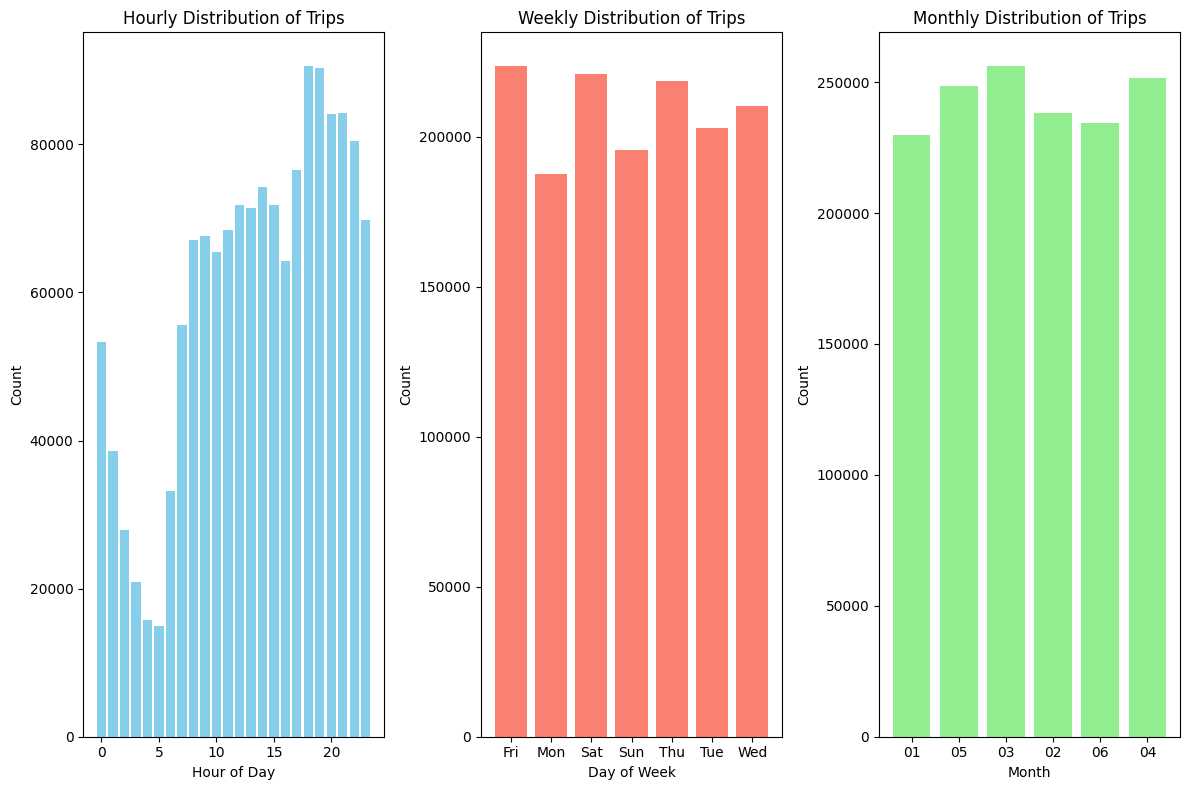

In [ ]:
from pyspark.sql.functions import hour, date_format, col

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 8))

# Hourly Count
hourly_count = train_df.groupby(hour(train_df['pickup_datetime'])).count().toPandas()
ax1.bar(hourly_count['hour(pickup_datetime)'], hourly_count['count'], color='skyblue')
ax1.set_xlabel('Hour of Day')
ax1.set_ylabel('Count')
ax1.set_title('Hourly Distribution of Trips')

# Weekly Count
day_order = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
weekly_count = train_df.groupby(date_format(train_df['pickup_datetime'], 'E').alias('day_of_week')).count().orderBy('day_of_week').toPandas()
ax2.bar(weekly_count['day_of_week'], weekly_count['count'], color='salmon')
ax2.set_xlabel('Day of Week')
ax2.set_ylabel('Count')
ax2.set_title('Weekly Distribution of Trips')

# Monthly Count
train_df_with_month = train_df.withColumn('pickup_month', date_format(train_df['pickup_datetime'], 'MM').alias('pickup_month'))
monthly_count = train_df_with_month.groupby('pickup_month').count().toPandas()
ax3.bar(monthly_count['pickup_month'], monthly_count['count'], color='lightgreen')
ax3.set_xlabel('Month')
ax3.set_ylabel('Count')
ax3.set_title('Monthly Distribution of Trips')

plt.tight_layout()
plt.show()


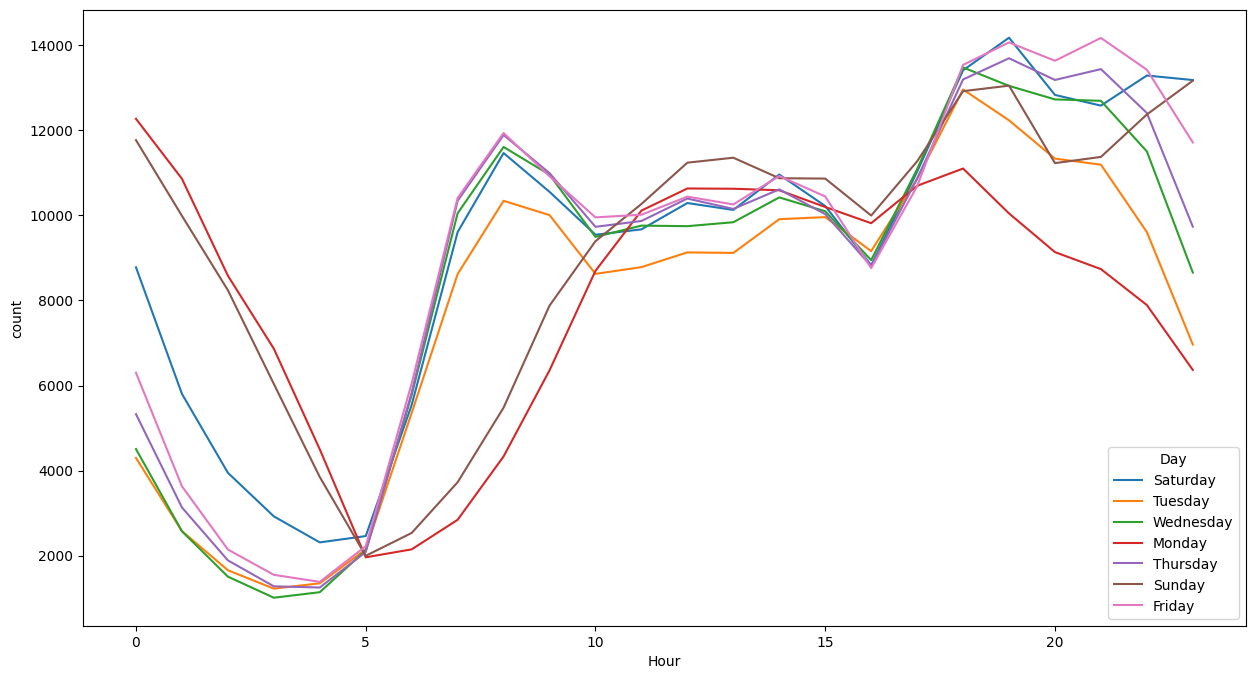

In [ ]:
from pyspark.sql.functions import hour, dayofweek, col

train_df_with_hour_day = train_df.withColumn('Hour', hour(train_df['pickup_datetime']))
train_df_with_hour_day = train_df_with_hour_day.withColumn('Day', dayofweek(train_df_with_hour_day['pickup_datetime']))

# Group by Hour and Day and count the number of trips
data_hour_day = train_df_with_hour_day.groupby('Hour', 'Day').count().toPandas()

# Map day of week numeric values to names
day_mapping = {
    1: 'Monday',
    2: 'Tuesday',
    3: 'Wednesday',
    4: 'Thursday',
    5: 'Friday',
    6: 'Saturday',
    7: 'Sunday'
}

data_hour_day['Day'] = data_hour_day['Day'].map(day_mapping)

# Plot the lineplot
plt.figure(figsize=(15, 8))
ax = sns.lineplot(data=data_hour_day, x='Hour', y='count', hue='Day', sort=True, legend='brief')

# Show the plot
plt.show()

In [ ]:
from pyspark.sql.functions import log1p

train_df = train_df.withColumn("log_trip_duration", log1p(col("trip_duration")))
train_df.show(5)

+---------+---------+-------------------+-------------------+---------------+-------------------+------------------+-------------------+------------------+------------------+-------------+---------+------------------+
|       id|vendor_id|    pickup_datetime|   dropoff_datetime|passenger_count|   pickup_longitude|   pickup_latitude|  dropoff_longitude|  dropoff_latitude|store_and_fwd_flag|trip_duration| distance| log_trip_duration|
+---------+---------+-------------------+-------------------+---------------+-------------------+------------------+-------------------+------------------+------------------+-------------+---------+------------------+
|id2875421|        2|2016-03-14 17:24:55|2016-03-14 17:32:30|              1|-73.982154846191406|40.767936706542969|-73.964630126953125|40.765602111816406|                 N|          455|0.9334063|6.1224928095143865|
|id2377394|        1|2016-06-12 00:43:35|2016-06-12 00:54:38|              1|-73.980415344238281|40.738563537597656|-73.99948120

In [ ]:
from pyspark.sql.types import DoubleType, IntegerType

# Convert columns to the desired data types
train_df = train_df.withColumn("vendor_id", col("vendor_id").cast(IntegerType()))
train_df = train_df.withColumn("pickup_datetime", col("pickup_datetime").cast("timestamp"))
train_df = train_df.withColumn("dropoff_datetime", col("dropoff_datetime").cast("timestamp"))
train_df = train_df.withColumn("passenger_count", col("passenger_count").cast(IntegerType()))
train_df = train_df.withColumn("pickup_longitude", col("pickup_longitude").cast(DoubleType()))
train_df = train_df.withColumn("pickup_latitude", col("pickup_latitude").cast(DoubleType()))
train_df = train_df.withColumn("dropoff_longitude", col("dropoff_longitude").cast(DoubleType()))
train_df = train_df.withColumn("dropoff_latitude", col("dropoff_latitude").cast(DoubleType()))
train_df = train_df.withColumn("store_and_fwd_flag", col("store_and_fwd_flag").cast("string"))
train_df = train_df.withColumn("trip_duration", col("trip_duration").cast(IntegerType()))
train_df = train_df.withColumn("distance", col("distance").cast(DoubleType()))

train_df.printSchema()


root
 |-- id: string (nullable = true)
 |-- vendor_id: integer (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- trip_duration: integer (nullable = true)
 |-- distance: double (nullable = true)
 |-- log_trip_duration: double (nullable = true)



In [ ]:
# Drop the 'store_and_fwd_flag' column because it is categorical - No much contribution in Time series Analysis
train_df = train_df.drop('store_and_fwd_flag')

In [ ]:
from pyspark.sql.functions import col, date_format

# Creating date feature from 'pick-up' column
train_df = train_df.withColumn('date', date_format(col('pickup_datetime'), 'yyyy-MM-dd'))

train_df.show(5)

+---------+---------+-------------------+-------------------+---------------+------------------+------------------+------------------+------------------+-------------+------------------+------------------+----------+
|       id|vendor_id|    pickup_datetime|   dropoff_datetime|passenger_count|  pickup_longitude|   pickup_latitude| dropoff_longitude|  dropoff_latitude|trip_duration|          distance| log_trip_duration|      date|
+---------+---------+-------------------+-------------------+---------------+------------------+------------------+------------------+------------------+-------------+------------------+------------------+----------+
|id2875421|        2|2016-03-14 17:24:55|2016-03-14 17:32:30|              1| -73.9821548461914| 40.76793670654297|-73.96463012695312|40.765602111816406|          455|0.9334062933921814|6.1224928095143865|2016-03-14|
|id2377394|        1|2016-06-12 00:43:35|2016-06-12 00:54:38|              1|-73.98041534423828|40.738563537597656|-73.9994812011718

In [ ]:
test_df = test_df.withColumn('date', date_format(col('pickup_datetime'), 'yyyy-MM-dd'))

test_df.show(5)

+---------+---------+-------------------+---------------+-------------------+------------------+-------------------+------------------+------------------+---------+----------+
|       id|vendor_id|    pickup_datetime|passenger_count|   pickup_longitude|   pickup_latitude|  dropoff_longitude|  dropoff_latitude|store_and_fwd_flag| distance|      date|
+---------+---------+-------------------+---------------+-------------------+------------------+-------------------+------------------+------------------+---------+----------+
|id3004672|        1|2016-06-30 23:59:58|              1|-73.988128662109375|40.732028961181641| -73.99017333984375|40.756679534912109|                 N|1.7043358|2016-06-30|
|id3505355|        1|2016-06-30 23:59:53|              1|-73.964202880859375| 40.67999267578125|-73.959808349609375|40.655403137207031|                 N|1.7123582|2016-06-30|
|id1217141|        1|2016-06-30 23:59:47|              1|  -73.9974365234375|40.737583160400391|-73.986160278320312|40.7

Visualizing Time series Data

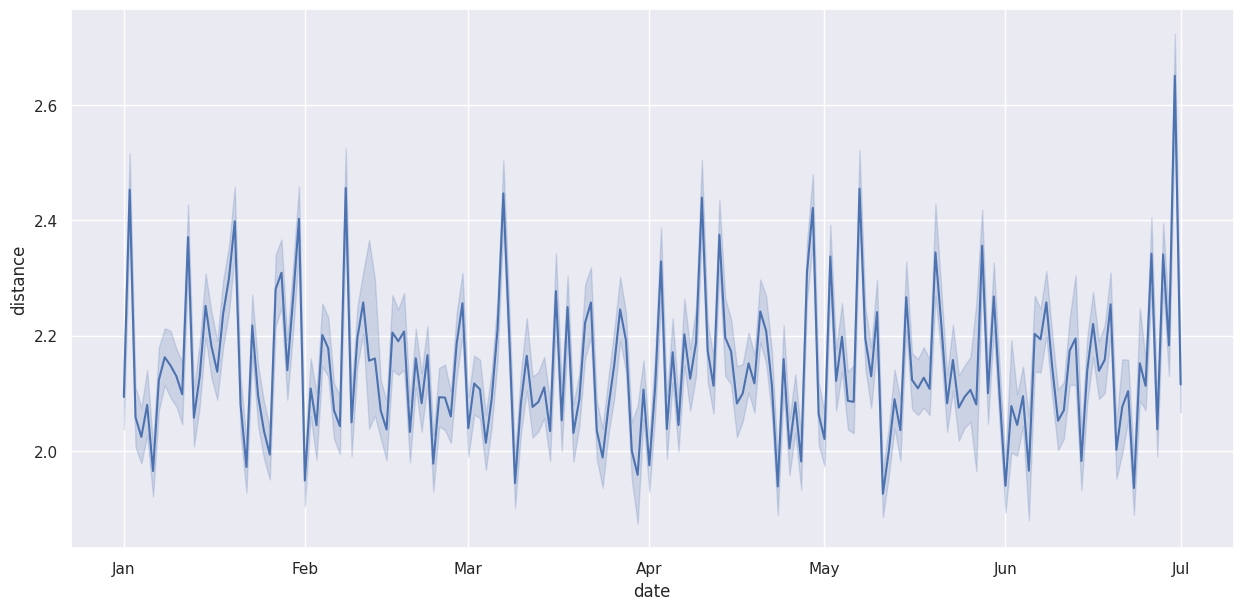

In [ ]:
from pyspark.sql.functions import month
import matplotlib.dates as mdates

train_df = train_df.withColumn("month", month("date"))

# Convert the PySpark DataFrame to Pandas DataFrame
train_pd = train_df.toPandas()

sns.set(rc={'figure.figsize': (15, 7)})

# Create a line plot
sns.lineplot(x="date", y="distance", data=train_pd)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.show()

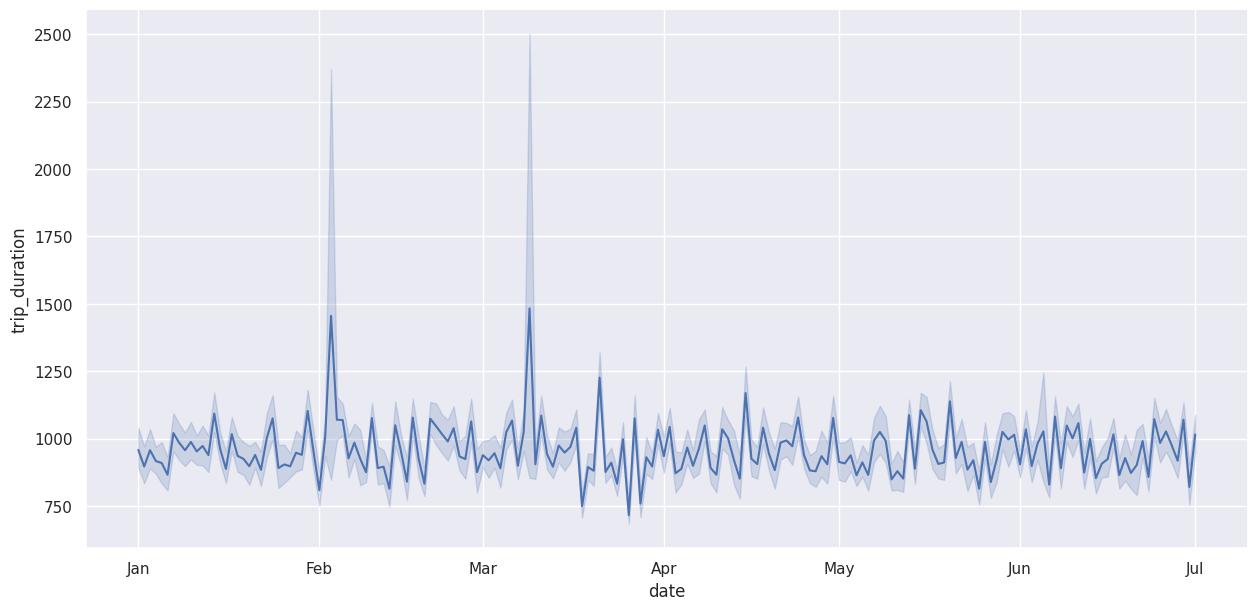

In [ ]:
train_dis = train_df.toPandas()

sns.set(rc={'figure.figsize': (15, 7)})

# Create a line plot
sns.lineplot(x="date", y="trip_duration", data=train_dis)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))

# Show the plot
plt.show()

In [ ]:
from pyspark.sql.functions import col, sum
from pyspark.sql.window import Window
from pyspark.sql import functions as F


# Convert the "date" column to a date type
train_df = train_df.withColumn("date", F.to_date("date"))

# Group by 'date' and aggregate the sum of 'distance'
agg_data = (
    train_df
    .groupBy("date")
    .agg(sum("distance").alias("distance_sum"))
    .orderBy("date")
)

# Convert the PySpark DataFrame to Pandas DataFrame
data_pd = agg_data.toPandas()

data_pd.head()


,date,distance_sum
0,2016-01-01,17009.972463
1,2016-01-02,14361.244445
2,2016-01-03,15603.329755
3,2016-01-04,14772.210750
4,2016-01-05,14729.378468


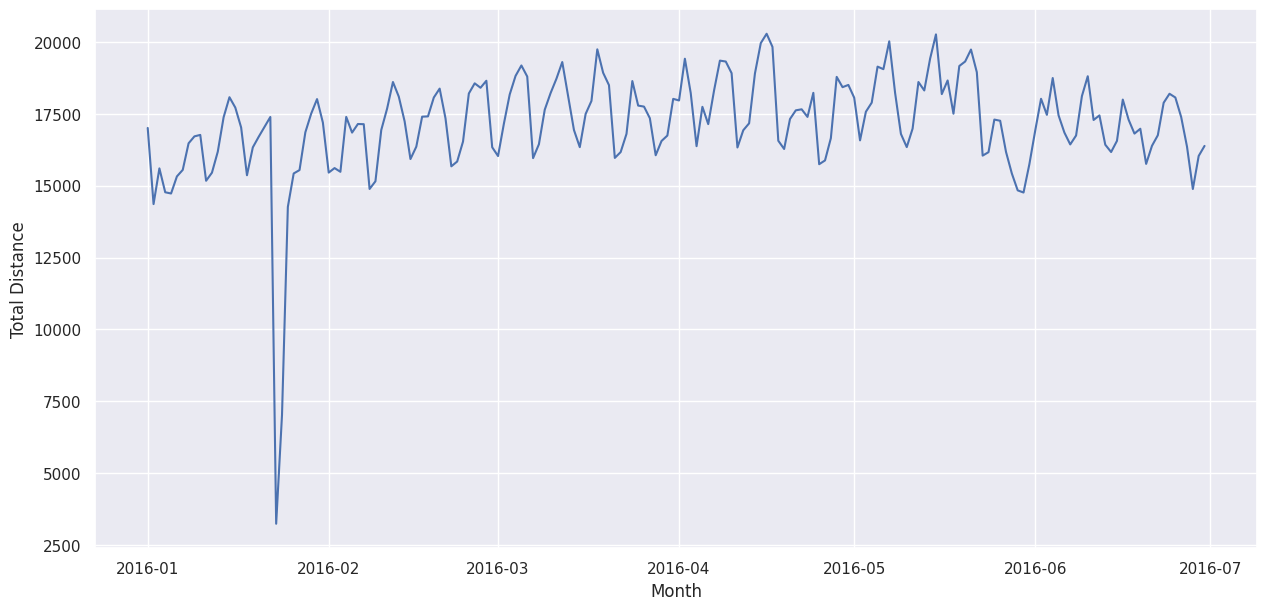

In [ ]:
sns.set(rc={'figure.figsize':(15, 7)})

# Create a line plot
plt.plot(data_pd['date'], data_pd['distance_sum'])
plt.xlabel('Month')
plt.ylabel('Total Distance')
plt.show()


In [ ]:
data_pd.head(10)

,date,distance_sum
0,2016-01-01,17009.972463
1,2016-01-02,14361.244445
2,2016-01-03,15603.329755
3,2016-01-04,14772.210750
4,2016-01-05,14729.378468
5,2016-01-06,15323.556976
6,2016-01-07,15551.103111
7,2016-01-08,16475.721235
8,2016-01-09,16716.763373
9,2016-01-10,16767.868429


Forecasting using FBPropet

In [ ]:
import prophet

In [ ]:
from prophet import Prophet

Forecasting Distance for next 30 days

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp65q0c9_3/6tkwe3j6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp65q0c9_3/6iqu9rzj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21642', 'data', 'file=/tmp/tmp65q0c9_3/6tkwe3j6.json', 'init=/tmp/tmp65q0c9_3/6iqu9rzj.json', 'output', 'file=/tmp/tmp65q0c9_3/prophet_model6bz_tb7i/prophet_model-20231220190830.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:08:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:08:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Text(58.125, 0.5, 'Total distance')

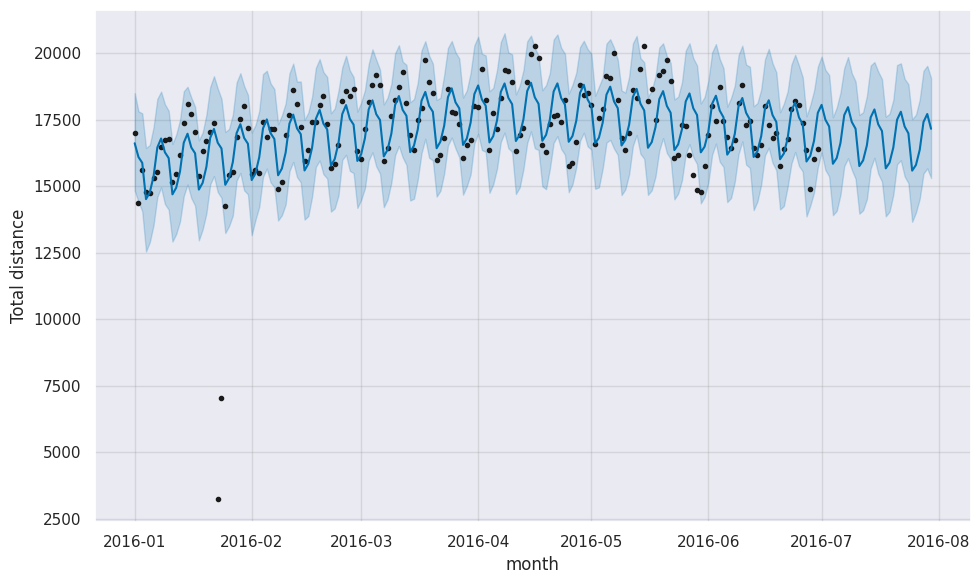

In [ ]:
data_pd['date'] = pd.to_datetime(data_pd['date'])
data_sum = data_pd[['date', 'distance_sum']].rename(columns={'date': 'ds', 'distance_sum': 'y'})

# Create and fit the Prophet model
m_sum = Prophet()
m_sum.fit(data_sum)

# Make future DataFrame for predictions
future_sum = m_sum.make_future_dataframe(periods=30)

# Generate predictions
forecast_sum = m_sum.predict(future_sum)

# Plot the forecast
fig_sum = m_sum.plot(forecast_sum)
plt.xlabel("month")
plt.ylabel("Total distance")

Forecasting Trip Duration for next 30 days

In [ ]:
data = (
    train_df.groupBy("date")
    .agg(F.sum("trip_duration").alias("trip_duration"))
    .select("date", "trip_duration")
)

# Convert the date column to datetime
data = data.withColumn("date", F.to_date("date"))

# Convert PySpark DataFrame to Pandas DataFrame
data_dur = data.toPandas()

In [ ]:
data_dur.head()

,date,trip_duration
0,2016-03-01,7038588
1,2016-04-25,5963640
2,2016-05-03,8744867
3,2016-01-28,8252150
4,2016-06-02,9033814


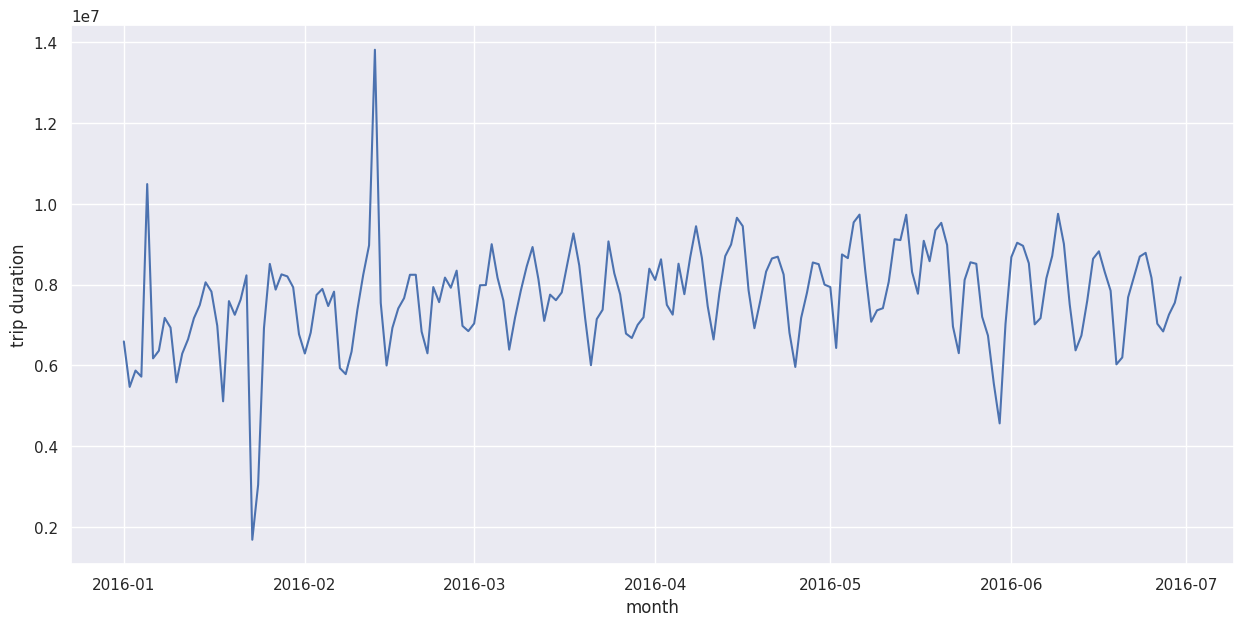

In [ ]:
sns.set(rc={'figure.figsize':(15, 7)})

# Create a line plot
sns.lineplot(x="date", y="trip_duration", data=data_dur)

# Show the plot
plt.xlabel("month")
plt.ylabel("trip duration")
plt.show()

In [ ]:
data_dur

,date,trip_duration
0,2016-03-01,7038588
1,2016-04-25,5963640
2,2016-05-03,8744867
3,2016-01-28,8252150
4,2016-06-02,9033814
...,...,...
177,2016-05-06,9729622
178,2016-03-18,9264728
179,2016-03-29,7003500
180,2016-03-23,7377718


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp65q0c9_3/8qv3esru.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp65q0c9_3/nnex9xqo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67544', 'data', 'file=/tmp/tmp65q0c9_3/8qv3esru.json', 'init=/tmp/tmp65q0c9_3/nnex9xqo.json', 'output', 'file=/tmp/tmp65q0c9_3/prophet_modelbl20ftdq/prophet_model-20231220190840.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:08:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:08:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Text(82.0, 0.5, 'trip duration')

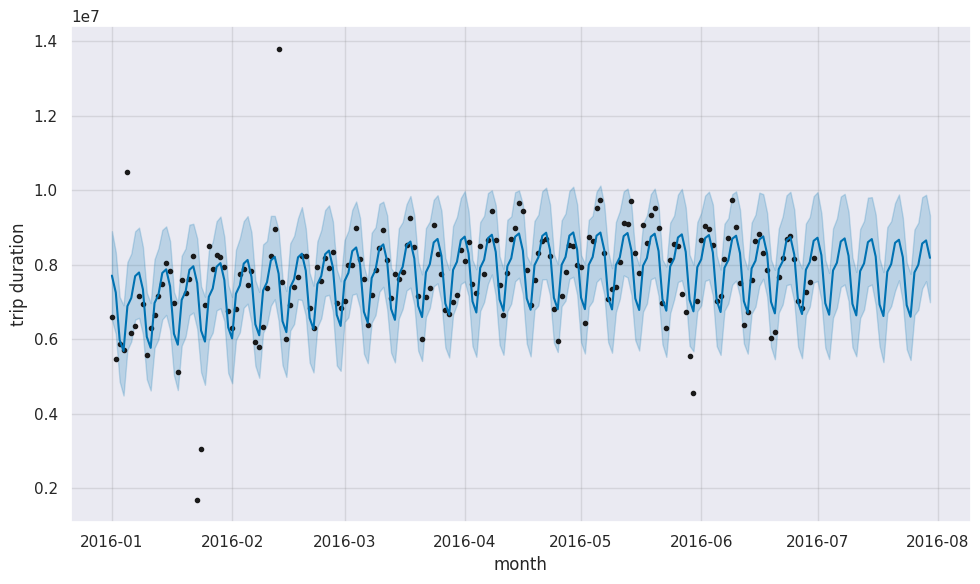

In [ ]:
data_dur['date'] = pd.to_datetime(data_dur['date'])

# Rename columns for Prophet
data_sum = data_dur[['date', 'trip_duration']].rename(columns={'date': 'ds', 'trip_duration': 'y'})

# Create and fit the Prophet model
m_sum = Prophet()
m_sum.fit(data_sum)

# Make future DataFrame for predictions
future_sum = m_sum.make_future_dataframe(periods=30)

# Generate predictions
forecast_sum = m_sum.predict(future_sum)

# Plot the forecast
fig_sum = m_sum.plot(forecast_sum)
plt.xlabel("month")
plt.ylabel("trip duration")